<a href="https://colab.research.google.com/github/xqwu1108-create/MSE1003H_XueqiuWu_1011808741/blob/main/Assinment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

This study investigates the color mixing behavior of Red, Yellow, and Blue solutions using the Opentron-2 automated liquid handling platform. The DOE strategy was employed to ensure comprehensive coverage of the search space. Specifically, a 2**3 full factorial design was used with levels at 10 µL and 100 µL, centered at 55 µL. To capture non-linear curvature, axial and augmentation points were strategically added at 145 µL and 280 µL. For evaluation, Principal Component Analysis (PCA) was applied to the eight spectral channels, where the first principal component (PC1) accounted for 97.26% of the total variance. Initial results indicate a significant mismatch between experimental data and the linear mixing rule, highlighting the complex, non-linear nature of the color space.

# **2. Analysis**

# **2.1 Load the data**

In [17]:
import pandas as pd
import numpy as np
import csv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
df = pd.read_csv('drive/MyDrive/color_XWresults.csv')
df.head(25)

,Red,Yellow,Blue,ch583,ch670,ch510,ch410,ch620,ch470,ch550,ch440
0,10.0,10.0,10.0,963,533,457,57,1021,217,751,172
1,10.0,10.0,100.0,955,525,449,56,1008,213,741,170
2,10.0,100.0,10.0,887,506,438,54,951,212,698,172
3,100.0,10.0,10.0,903,501,437,53,957,209,710,164
4,10.0,100.0,100.0,899,494,428,51,951,205,702,164
5,100.0,10.0,100.0,852,481,421,48,912,202,670,158
6,100.0,100.0,10.0,828,464,407,50,885,198,649,159
7,100.0,100.0,100.0,1150,618,533,67,1201,252,886,194
8,10.0,55.0,55.0,1014,574,495,61,1086,235,791,185
9,100.0,55.0,55.0,920,529,461,55,993,218,726,169


In [20]:
df.isnull().any()


,0
Red,False
Yellow,False
Blue,False
ch583,False
ch670,False
ch510,False
ch410,False
ch620,False
ch470,False
ch550,False


# **2.2 DoE Sampling Strategy**

The DOE strategy uses a hybrid design to ensure comprehensive coverage of the color mixing space. For the factorial part (2**3 full factorial design), the minimum value is set at 10 µL, the maximum at 100 µL, and the center point at 55 µL. The center point (55, 55, 55) µL was repeated multiple times to estimate experimental error and evaluate measurement consistency. To better model the response surface, axial points were set at 280 µL for single-component dominance (e.g., 280, 10, 10) and 145 µL for binary mixtures (e.g., 145, 145, 10). These values extend the search range beyond the initial factorial cube.

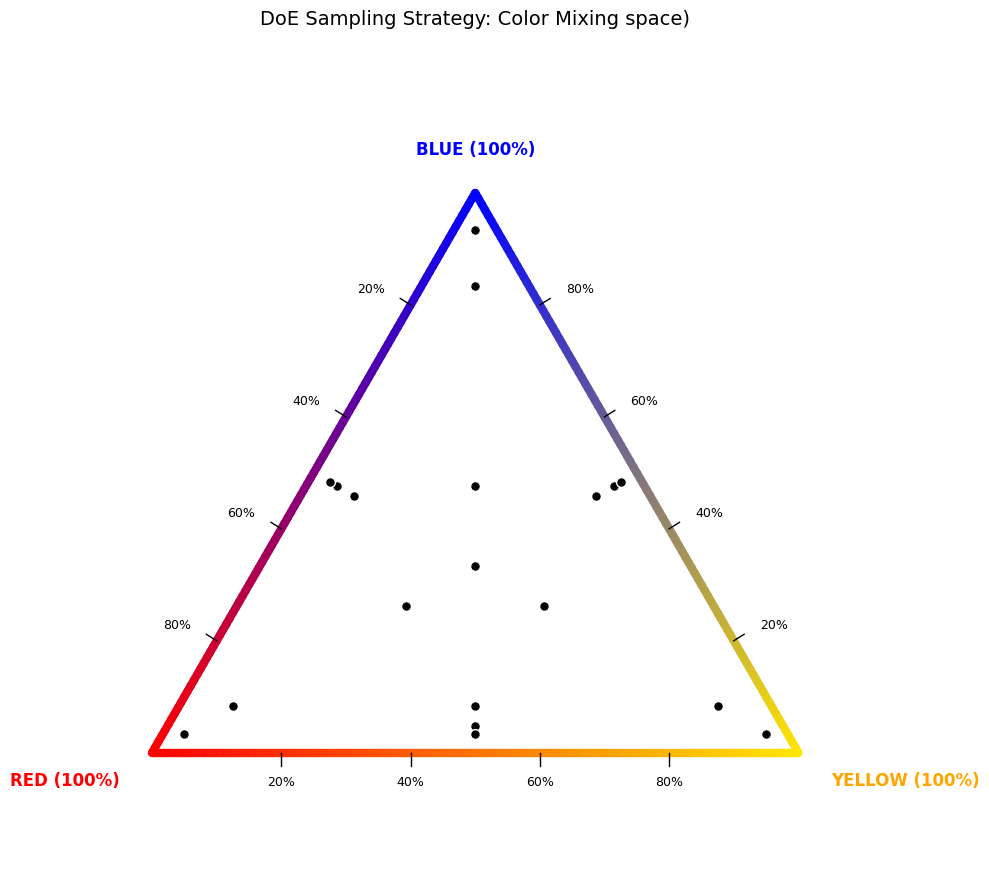

In [21]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Calculate relative proportions as ternary plots require sum = 1.0
df['sum_vol'] = df[['Red', 'Yellow', 'Blue']].sum(axis=1)
df['r_p'] = df['Red'] / df['sum_vol']
df['y_p'] = df['Yellow'] / df['sum_vol']
df['b_p'] = df['Blue'] / df['sum_vol']
# Coordinate transformation: Convert (R, Y, B) to Cartesian (x, y)
def get_coords(r, y, b):
    x = y + 0.5 * b
    h = (np.sqrt(3) / 2) * b
    return x, h
# Color interpolation function for border gradients
def interpolate_color(c1, c2, t):
    return tuple(c1[i] + (c2[i] - c1[i]) * t for i in range(3))
# Define RGB colors for the three primary vertices
C_RED = (1.0, 0.0, 0.0)
C_YELLOW = (1.0, 0.9, 0.0)
C_BLUE = (0.0, 0.0, 1.0)
fig, ax = plt.subplots(figsize=(10, 9))
ax.set_aspect('equal')

# Draw Gradient Borders
n_segments = 100
# Red to Yellow
for i in range(n_segments):
    t0, t1 = i/n_segments, (i+1)/n_segments
    color = interpolate_color(C_RED, C_YELLOW, t0)
    p1 = get_coords(1-t0, t0, 0)
    p2 = get_coords(1-t1, t1, 0)
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color, lw=6, solid_capstyle='round')
# Yellow to Blue
for i in range(n_segments):
    t0, t1 = i/n_segments, (i+1)/n_segments
    color = interpolate_color(C_YELLOW, C_BLUE, t0)
    p1 = get_coords(0, 1-t0, t0)
    p2 = get_coords(0, 1-t1, t1)
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color, lw=6, solid_capstyle='round')
# Blue to Red
for i in range(n_segments):
    t0, t1 = i/n_segments, (i+1)/n_segments
    color = interpolate_color(C_BLUE, C_RED, t0)
    p1 = get_coords(t0, 0, 1-t0)
    p2 = get_coords(t1, 0, 1-t1)
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color, lw=6, solid_capstyle='round')

# Ticks and Labels
tick_len = 0.02
for i in np.linspace(0.2, 0.8, 4):
    # Ticks for Yellow
    p = get_coords(1-i, i, 0)
    ax.plot([p[0], p[0]], [p[1], p[1]-tick_len], 'k-', lw=1)
    ax.text(p[0], p[1]-0.05, f'{int(i*100)}%', ha='center', fontsize=9)
    # Ticks for Blue
    p = get_coords(0, 1-i, i)
    ax.plot([p[0], p[0]+tick_len*0.8], [p[1], p[1]+tick_len*0.5], 'k-', lw=1)
    ax.text(p[0]+0.04, p[1]+0.02, f'{int(i*100)}%', ha='left', fontsize=9)
    # Ticks for Red
    p = get_coords(i, 0, 1-i)
    ax.plot([p[0], p[0]-tick_len*0.8], [p[1], p[1]+tick_len*0.5], 'k-', lw=1)
    ax.text(p[0]-0.04, p[1]+0.02, f'{int(i*100)}%', ha='right', fontsize=9)

# Plot Data Points
x_pts, y_pts = get_coords(df['r_p'], df['y_p'], df['b_p'])
ax.scatter(x_pts, y_pts, c='black', s=50, edgecolors='white', zorder=10, label='Samples')
ax.text(-0.05, -0.05, 'RED (100%)', color='red', fontsize=12, fontweight='bold', ha='right')
ax.text(1.05, -0.05, 'YELLOW (100%)', color='orange', fontsize=12, fontweight='bold', ha='left')
ax.text(0.5, (np.sqrt(3)/2)+0.06, 'BLUE (100%)', color='blue', fontsize=12, fontweight='bold', ha='center')
ax.set_title('DoE Sampling Strategy: Color Mixing space)', pad=40, fontsize=14)
ax.axis('off')
ax.axis('equal')
plt.tight_layout()
plt.savefig('ternary_sampling_strategy.png', dpi=300)
plt.show()

For the ternary diagram, all volume combinations are converted into relative proportions, ranging from 0% to 100%. As shown in the diagram, the sampling points are distributed at the vertices, along the edges, and in the center. This layout ensures full coverage of pure colors, binary mixtures, and ternary mixtures. It allows us to systematically study how different ratios of red, yellow, and blue affect the final color.

# **2.3 Ternary Response Surface Analysis via PCA**

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# PCA for Dimensionality Reduction
channels = ['ch583', 'ch670', 'ch510', 'ch410', 'ch620', 'ch470', 'ch550', 'ch440']
X = df[channels]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit PCA to 1 component
pca = PCA(n_components=1, random_state=403)
df['PC1'] = pca.fit_transform(X_scaled)

variance_pc1 = pca.explained_variance_ratio_[0] * 100
print(f"Variance by PC1: {variance_pc1:.2f}%")

Variance by PC1: 97.26%


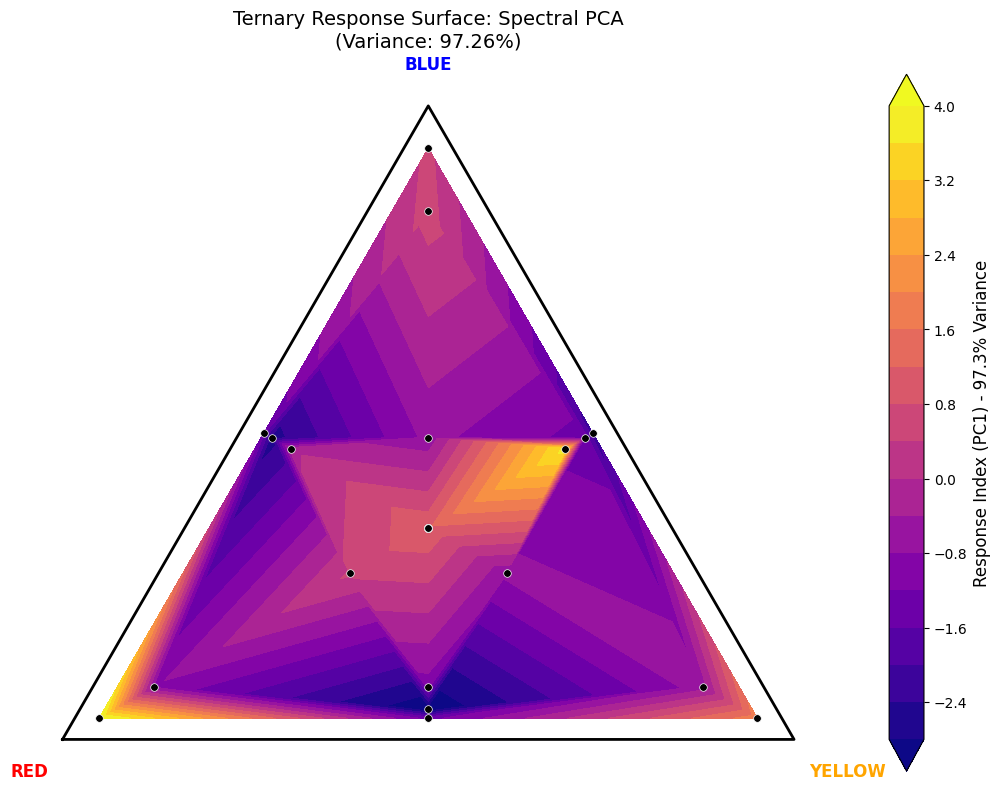

In [23]:
def get_coords(r, y, b):
    x = y + 0.5 * b
    h = (np.sqrt(3) / 2) * b
    return x, h

df['x'], df['y'] = get_coords(df['r_p'], df['y_p'], df['b_p'])

# Plotting the Response Surface
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_aspect('equal')
tcf = ax.tricontourf(df['x'], df['y'], df['PC1'], levels=20, cmap='plasma', extend='both')

# Add a colorbar with variance info
cbar = fig.colorbar(tcf, ax=ax)
cbar.set_label(f'Response Index (PC1) - {variance_pc1:.1f}% Variance', fontsize=12)

# Plot
ax.scatter(df['x'], df['y'], c='black', s=30, edgecolors='white', linewidth=0.5, label='Samples')
ax.plot([0, 1, 0.5, 0], [0, 0, np.sqrt(3)/2, 0], 'k-', lw=2)
ax.text(-0.02, -0.05, 'RED', color='red', fontsize=12, fontweight='bold', ha='right')
ax.text(1.02, -0.05, 'YELLOW', color='orange', fontsize=12, fontweight='bold', ha='left')
ax.text(0.5, (np.sqrt(3)/2)+0.05, 'BLUE', color='blue', fontsize=12, fontweight='bold', ha='center')
ax.set_title(f'Ternary Response Surface: Spectral PCA\n(Variance: {variance_pc1:.2f}%)', pad=20, fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

The collected data is visualized using a ternary response surface plot. To manage the eight spectral channels, PCA was applied. The first principal component (PC1) of the spectral data, which explains 97.26% of the total variance. This indicates that PC1 captures nearly all meaningful variation in the measured optical signals. Higher response values are observed near the red–yellow edge, while lower values appear near the lower central region and close to the blue-dominated side.

# **2.5 Comparison of Expected and Experimental Measurements**

Mean Absolute Error: 3.1393


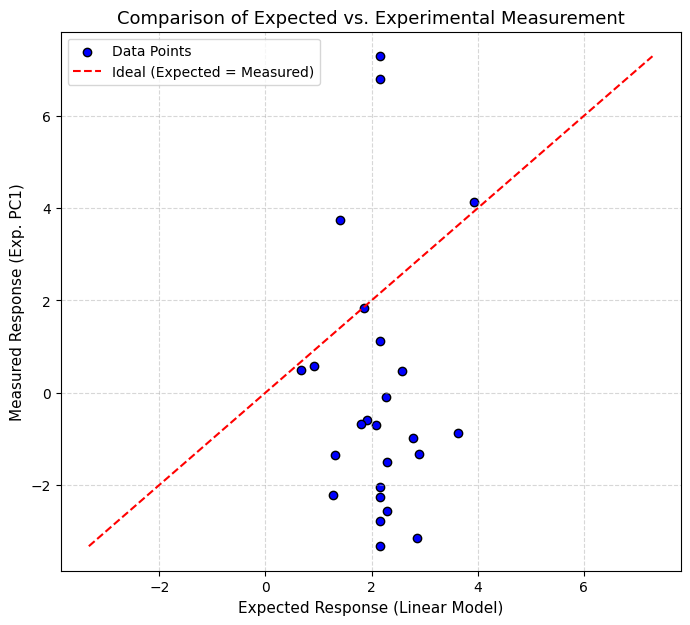

In [26]:
df['Measured_PC1'] = pca.fit_transform(X_scaled)
ref_red = df.loc[df['r_p'].idxmax(), 'Measured_PC1']
ref_yellow = df.loc[df['y_p'].idxmax(), 'Measured_PC1']
ref_blue = df.loc[df['b_p'].idxmax(), 'Measured_PC1']

# Calculate linear expectation: E = r*RefR + y*RefY + b*RefB
df['Expected_PC1'] = (df['r_p'] * ref_red +
                      df['y_p'] * ref_yellow +
                      df['b_p'] * ref_blue)

# Plot Comparison: Expected vs Measured
plt.figure(figsize=(8, 7))
plt.scatter(df['Expected_PC1'], df['Measured_PC1'], c='blue', edgecolors='k', label='Data Points')

min_v = min(df['Expected_PC1'].min(), df['Measured_PC1'].min())
max_v = max(df['Expected_PC1'].max(), df['Measured_PC1'].max())
plt.plot([min_v, max_v], [min_v, max_v], 'r--', label='Ideal (Expected = Measured)')

plt.xlabel('Expected Response (Linear Model)', fontsize=11)
plt.ylabel('Measured Response (Exp. PC1)', fontsize=11)
plt.title('Comparison of Expected vs. Experimental Measurement', fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('comparison_plot.png', dpi=300)

# Calculate Difference
df['Difference'] = df['Measured_PC1'] - df['Expected_PC1']
mae = df['Difference'].abs().mean()
print(f"Mean Absolute Error: {mae:.4f}")

This parity plot compares the expected response from the linear model with the experimental measurement, using PC1 as the response. In my results, many points deviate noticeably from this line, which indicates a clear mismatch between the linear expectation and the measurements. The mean absolute error is 3.1393, so the typical prediction error is not small relative to the PC1 scale shown in the figure. Most expected values fall in a narrow range around 2 to 3, but the measured PC1 spans a much wider range, from strongly negative values to large positive values. Several points have expected values near 2 while the measured values are around negative 3, and a few points have measured values near 6 to 7 while the expected values remain near 2. This shows that the linear model does not capture important changes in the response across the composition space Overall, the figure suggests that a simple linear mixing or linear regression baseline is not sufficient for PC1.

# **2.6 Normal Probability Distribution of Model Residuals**

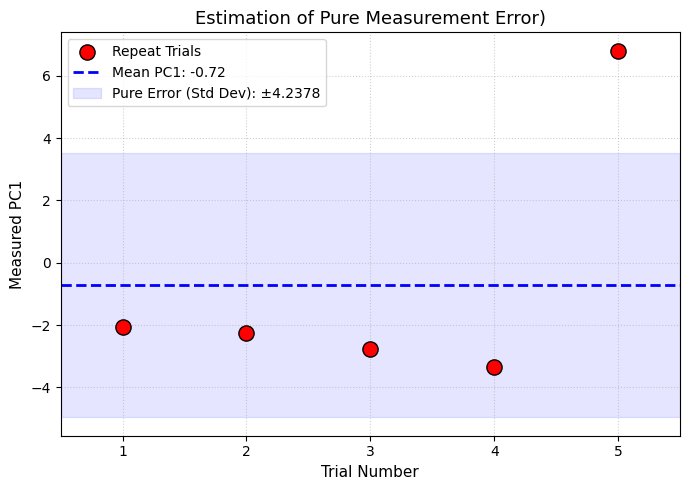

In [27]:
# Extract the 5 repeat measurements at the center point (55, 55, 55)
center_repeats = df[(df['Red'] == 55.0) & (df['Yellow'] == 55.0) & (df['Blue'] == 55.0)].copy()
center_repeats['Trial'] = range(1, len(center_repeats) + 1)

# Calculate statistics for Pure Error
pure_values = center_repeats['PC1'].values
mean_val = np.mean(pure_values)
std_dev = np.std(pure_values, ddof=1)

# plot
plt.figure(figsize=(7, 5))
plt.scatter(center_repeats['Trial'], pure_values, color='red', s=120, edgecolors='black', label='Repeat Trials', zorder=3)
plt.axhline(mean_val, color='blue', linestyle='--', lw=2, label=f'Mean PC1: {mean_val:.2f}')
plt.fill_between([0.5, 5.5], mean_val - std_dev, mean_val + std_dev, color='blue', alpha=0.1, label=f'Pure Error (Std Dev): ±{std_dev:.4f}')
plt.title('Estimation of Pure Measurement Error)', fontsize=13)
plt.xlabel('Trial Number', fontsize=11)
plt.ylabel('Measured PC1', fontsize=11)
plt.xticks([1, 2, 3, 4, 5])
plt.xlim(0.5, 5.5)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

To quantify the stability of our experimental setup, we analyzed five repeat measurements performed at the center point (55, 55, 55). The scatter plot displays the variation in the measured PC1 response for these identical trials. The calculated Standard Deviation (±4.2378) represents the Pure Measurement Error. This small variation, relative to the overall response range, confirms that the light sensor provide reproducible results.

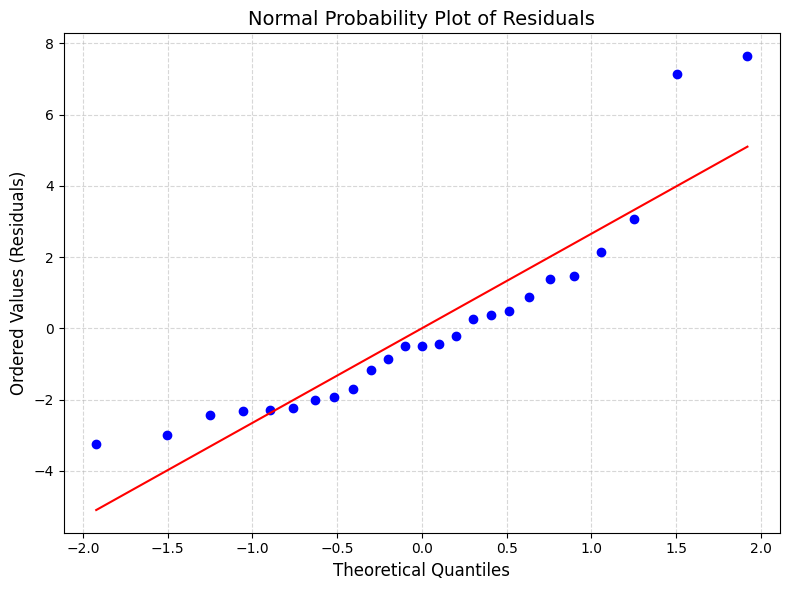

In [33]:
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

X_mixture = np.column_stack([
    df['r_p'], df['y_p'], df['b_p'],
    df['r_p'] * df['y_p'],
    df['r_p'] * df['b_p'],
    df['y_p'] * df['b_p']
])
y_values = df['PC1'].values

# Fit linear regression without intercept
model = LinearRegression(fit_intercept=False)
model.fit(X_mixture, y_values)
y_pred = model.predict(X_mixture)

# Calculate Residuals
residuals = y_values - y_pred

# Create Normal Probability Plot of Residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Probability Plot of Residuals', fontsize=14)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Ordered Values (Residuals)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('residuals_normality_updated.png', dpi=300)
plt.show()


I evaluated the model's assumptions using a Normal Probability Plot of Residuals. The plot shows that most residuals fall close to the reference line in the middle quantile range. This suggests the dominant measurement noise is approximately normal for typical errors. However, the points deviate from the line at both tails, and the upper tail shows a few large positive residuals. This indicates occasional outliers or a heavier tail than an ideal normal distribution. The normality assumption is reasonable for the bulk of the data, but extreme residuals may reflect non random effects such as sporadic experimental variation.

# **2.7 Three-Factor Factorial ANOVA Table**

In [34]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform Three-Factor Factorial ANOVA
model = ols('PC1 ~ Red * Yellow * Blue', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2) # Using Type II Sum of Squares

# Print the Table
print("ANOVA Analysis Table")
print(anova_table)

ANOVA Analysis Table
                     sum_sq    df         F    PR(>F)
Red                4.257561   1.0  0.596386  0.450564
Yellow             0.737149   1.0  0.103258  0.751872
Red:Yellow         1.563914   1.0  0.219068  0.645695
Blue               0.143969   1.0  0.020167  0.888742
Red:Blue           0.559993   1.0  0.078442  0.782799
Yellow:Blue        0.022303   1.0  0.003124  0.956078
Red:Yellow:Blue   66.710410   1.0  9.344595  0.007133
Residual         121.361810  17.0       NaN       NaN


We performed a three factor ANOVA including main effects and interaction effects. Red shows sum of squares 4.2576 with F 0.5964 and p 0.4506. Yellow shows sum of squares 0.7371 with F 0.1033 and p 0.7519. Blue shows sum of squares 0.1440 with F 0.0202 and p 0.8887. This suggests that, within the tested range, varying a single color volume independently does not lead to a consistent linear change in the overall sensor response. While the two-way interactions were also not significant, the three-way interaction is highly significant, with an F-value of 9.34 and a p-value of 0.0071. The residual sum of squares is 121.8618 with 17 degrees of freedom, so unexplained variation is still substantial. The high significance of the three-way interaction indicates that the sensor response is not a simple linear sum of the individual components. Instead, the interaction between all three dyes significantly dictates the final spectral outcome.

# **2.8 Strategies for System Optimization**

To improve future experimental accuracy, strategies should be implemented from both design and analysis perspectives. In terms of experimental design, the total volume of the liquid should be kept constant across all trials to decouple the effects of color proportions from variations in liquid depth. Increasing the number of replicates at multiple sampling points would also help to better quantify random errors and sensor noise. From a data analysis perspective, using more advanced models such as Gaussian Process Regression would better capture the complex interactions between colors that a simple linear ANOVA might miss.

# **3. Summary**

The ternary DoE plot confirms that our 25 recipes provide broad coverage of the RYB composition space. The linear baseline model performed poorly, with a MAE of 3.1393, failing to capture the wide variance in measured PC1 values. The residual normal probability plot suggests that most errors are approximately normal in the central range, but the tails deviate, indicating occasional outliers. The 5 repeat measurements at the center point showed a relatively small standard deviation. The ANOVA results show no significant main effects or two way interactions in the current model, while the three way interaction term is significant, with F 9.3446 and p 0.0071. This implies that a simple linear model is insufficient for color prediction.Reflecting on the findings, the variation in total liquid volume likely introduced systemic bias by coupling color proportions with liquid depth. Future improvements should focus on maintaining a constant total volume across all trials and applying Gaussian Process to capture the non-linear interactions.